In [2]:
!pip install opendatasets

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import opendatasets as od
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Loading data

In [7]:
od.download("https://www.kaggle.com/datasets/bensalem14/sgcc-dataset")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mukiibirogers
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/bensalem14/sgcc-dataset


100%|██████████| 51.2M/51.2M [00:00<00:00, 87.9MB/s]


In [30]:
df = pd.read_csv("sgcc-dataset/datasetsmall.csv")
df.head()

,01/01/2014,01/02/2014,01/03/2014,01/04/2014,01/05/2014,01/06/2014,01/07/2014,01/08/2014,01/09/2014,01/10/2014,...,1/19/2014,1/20/2014,1/21/2014,1/22/2014,1/23/2014,1/24/2014,1/25/2014,1/26/2014,CONS_NO,FLAG
0,2401.0,2500.0,2674.0,2432.00,2231.00,1942.00,2752.00,1244.00,2069.0,2360.0,...,1774.00,2089.0,1300.0,2419.0,2462.0,1177.00,340.00,2272.00,A0E791400CF1C48C43DC26A68227854A,1
1,3318.0,282.0,540.0,5670.00,4854.00,4170.00,4848.00,3546.00,4416.0,3966.0,...,3876.00,3228.0,3054.0,3840.0,1422.0,1956.00,1380.00,96.00,B415F931D3BFB17ACEF48BC648B04FC2,1
2,1020.8,1097.4,1377.4,1408.80,1414.80,1387.40,1444.60,1325.00,1461.6,1253.2,...,1214.60,1285.4,1279.6,1188.6,1362.6,1286.00,1267.60,1444.00,DE8E1EAE4E578C0CEF92D1E23499888F,1
3,0.0,1183.8,1190.4,1183.80,0.00,1154.40,1166.40,1183.80,1169.4,1174.2,...,0.00,1072.8,1090.8,1090.2,1101.0,1079.40,1121.40,1145.40,2952491E940C9040B188B3C9095910D6,0
4,1445.7,1348.2,1281.9,1276.35,1219.95,1289.85,1298.55,1326.15,1410.6,1376.7,...,1331.85,1392.9,1213.2,1463.1,1405.5,1240.05,1190.25,1455.45,DBEED8FD0E7F5E0D1BAF1F86F4983459,1


In [31]:
df.shape

(25863, 28)

In [32]:
# dropping CONS_NO because it is irrelevant
df.drop(columns=['CONS_NO'], inplace=True)

In [33]:
# adding 0 to the header dates without 0s at the start
new_cols=[]
for i in df.columns:
    if i[0]=='1':
        new_cols.append("0"+i)
    else :
        new_cols.append(i)

df.columns=new_cols
df.head()

,01/01/2014,01/02/2014,01/03/2014,01/04/2014,01/05/2014,01/06/2014,01/07/2014,01/08/2014,01/09/2014,01/10/2014,...,01/18/2014,01/19/2014,01/20/2014,01/21/2014,01/22/2014,01/23/2014,01/24/2014,01/25/2014,01/26/2014,FLAG
0,2401.0,2500.0,2674.0,2432.00,2231.00,1942.00,2752.00,1244.00,2069.0,2360.0,...,2369.0,1774.00,2089.0,1300.0,2419.0,2462.0,1177.00,340.00,2272.00,1
1,3318.0,282.0,540.0,5670.00,4854.00,4170.00,4848.00,3546.00,4416.0,3966.0,...,3258.0,3876.00,3228.0,3054.0,3840.0,1422.0,1956.00,1380.00,96.00,1
2,1020.8,1097.4,1377.4,1408.80,1414.80,1387.40,1444.60,1325.00,1461.6,1253.2,...,1351.4,1214.60,1285.4,1279.6,1188.6,1362.6,1286.00,1267.60,1444.00,1
3,0.0,1183.8,1190.4,1183.80,0.00,1154.40,1166.40,1183.80,1169.4,1174.2,...,1158.6,0.00,1072.8,1090.8,1090.2,1101.0,1079.40,1121.40,1145.40,0
4,1445.7,1348.2,1281.9,1276.35,1219.95,1289.85,1298.55,1326.15,1410.6,1376.7,...,1398.6,1331.85,1392.9,1213.2,1463.1,1405.5,1240.05,1190.25,1455.45,1


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25863 entries, 0 to 25862
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   01/01/2014  25863 non-null  float64
 1   01/02/2014  25861 non-null  float64
 2   01/03/2014  25858 non-null  float64
 3   01/04/2014  25861 non-null  float64
 4   01/05/2014  25861 non-null  float64
 5   01/06/2014  25861 non-null  float64
 6   01/07/2014  25860 non-null  float64
 7   01/08/2014  25863 non-null  float64
 8   01/09/2014  25862 non-null  float64
 9   01/10/2014  25863 non-null  float64
 10  01/11/2014  25862 non-null  float64
 11  01/12/2014  25863 non-null  float64
 12  01/13/2014  25863 non-null  float64
 13  01/14/2014  25861 non-null  float64
 14  01/15/2014  25859 non-null  float64
 15  01/16/2014  25860 non-null  float64
 16  01/17/2014  25857 non-null  float64
 17  01/18/2014  25857 non-null  float64
 18  01/19/2014  25857 non-null  float64
 19  01/20/2014  25856 non-nul

## Data cleaning

In [35]:
# Handling missing values using interpolation
print(df.isna().sum().sum())

125


In [36]:
df.interpolate(method='linear', axis=1, inplace=True)

In [40]:
# Nomalization
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Standardization
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

<Axes: xlabel='FLAG', ylabel='Count'>

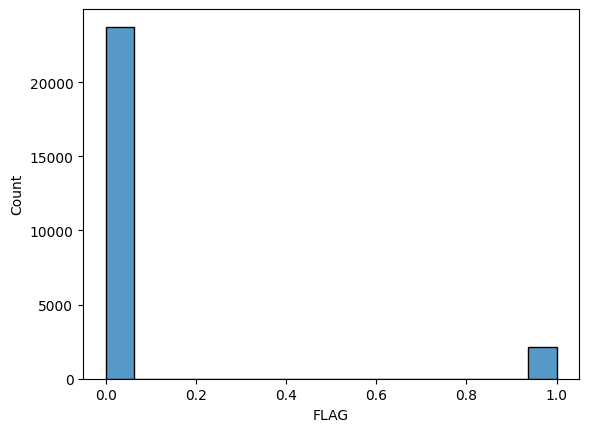

In [43]:
# plot for distribution of target
plt.figure()